In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import terminalLogic
from terminalLogic import Algo
import client
from client import engine
from typing import Optional, Dict, Any, List
from ciso8601 import parse_datetime
from requests import Request, Session, Response
import sys
import hmac
import urllib.parse
import time
import plotly.graph_objects as go
from ta import add_all_ta_features
from ta.utils import dropna
from datetime import datetime
plt.rcParams["figure.figsize"] = (100,10)


In [2]:
df = pd.read_csv('minute.csv')

In [3]:
df.tail(10)
df = df[::-1]
df = df.drop(df.columns[0], axis = 1) 

df

,startTime,time,open,high,low,close,volume,9-min,21-min,signal,market_returns,trend_returns,entry,ma,ratio,position,entryR,range_returns,sign
478,2021-10-11T19:11:00+00:00,1.633979e+12,57475.0,57475.0,57475.0,57475.0,0.000000e+00,57466.444444,57436.619048,1.0,0.000000,0.000122,0.0,57466.444444,1.000149,-1.0,0.0,-0.000000,1.0
477,2021-10-11T19:10:00+00:00,1.633979e+12,57468.0,57484.0,57456.0,57475.0,1.639250e+05,57468.222222,57430.095238,1.0,0.000122,-0.000070,0.0,57468.222222,1.000118,-1.0,0.0,-0.000122,1.0
476,2021-10-11T19:09:00+00:00,1.633979e+12,57472.0,57472.0,57452.0,57468.0,3.304647e+04,57456.888889,57425.428571,1.0,-0.000070,-0.000452,0.0,57456.888889,1.000193,-1.0,0.0,0.000070,-1.0
475,2021-10-11T19:08:00+00:00,1.633979e+12,57498.0,57499.0,57472.0,57472.0,1.159492e+05,57444.111111,57421.095238,1.0,-0.000452,-0.000574,0.0,57444.111111,1.000485,-1.0,0.0,0.000452,-1.0
474,2021-10-11T19:07:00+00:00,1.633979e+12,57531.0,57536.0,57497.0,57498.0,2.241915e+05,57433.666667,57415.714286,1.0,-0.000574,0.000713,0.0,57433.666667,1.001120,-1.0,0.0,0.000574,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2021-10-11T11:17:00+00:00,1.633951e+12,56121.0,56200.0,56121.0,56197.0,1.446364e+06,56062.333333,56193.571429,-1.0,0.001353,0.000160,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-10-11T11:16:00+00:00,1.633951e+12,56130.0,56150.0,56088.0,56121.0,2.464810e+05,56073.444444,56205.000000,-1.0,-0.000160,-0.001248,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-10-11T11:15:00+00:00,1.633951e+12,56060.0,56130.0,56056.0,56130.0,4.376744e+05,56090.111111,56219.095238,-1.0,0.001248,-0.002411,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-10-11T11:14:00+00:00,1.633951e+12,55925.0,56060.0,55925.0,56060.0,2.326389e+06,56117.222222,56237.666667,-1.0,0.002411,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


## mean rev algo

In [4]:
ma = 30
# calc rate ofreturn close to close
df['returns'] = np.log(df["close"]).diff()
# add column to keep track of mean or moving average
df['ma'] = df['close'].rolling(ma).mean()
# to decide when too far away from mean add column called ratio
df['ratio'] = df['close'] / df['ma']
# create variable for price points that might work
percentiles = [5, 10, 50, 90, 95]
# get a look at where percentiles are w numpy percential function on btc ratio column
np.percentile(df['ratio'].dropna(), percentiles)
p = np.percentile(df['ratio'].dropna(), percentiles)

In [5]:
# Define place where we short at 95th percentile and long at 5th
short = p[-1]
long = p[0]
# use np.where which is numpys version of excels 'if' function
# add column to df for position value
# look at ratio column -1 indicates short otherwise nan
df['position'] = np.where(df.ratio > short, -1, np.nan)
# when long position at 1 instead of np.nan we leave btc['position'] where it is.
df['position'] = np.where(df.ratio < long, 1, df['position'])
# This strat isnt neutral, its always in a long or short.
df['position'] = df['position'].ffill()
df['strat_return'] = df['returns'] * df['position'].shift()

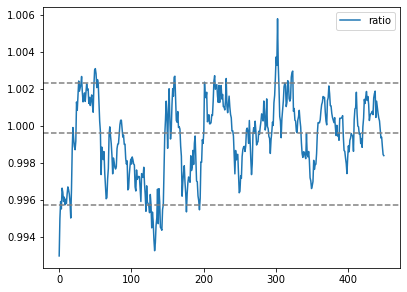

In [6]:
# visual look at ratio column
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

df['ratio'].head(500).dropna().plot(legend = True)
plt.axhline(p[0], c= (.5,.5,.5), ls='--')
plt.axhline(p[2], c= (.5,.5,.5), ls='--')
plt.axhline(p[-1], c= (.5,.5,.5), ls='--');
# can see ratio move around mean

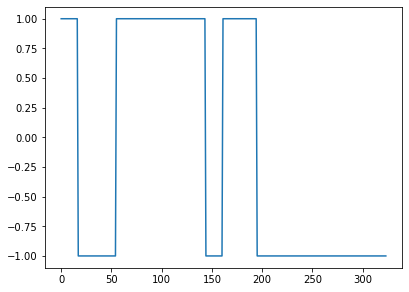

In [7]:
# df.position.dropna().plot()
plt.plot(df.head(2500).position.dropna())
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]


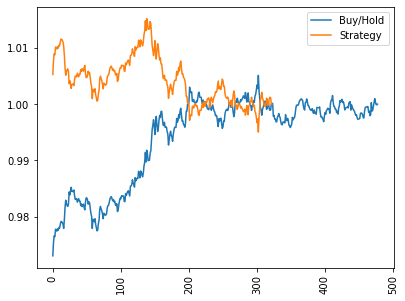

In [8]:
plt.plot(np.exp(df['returns'].dropna()).cumprod(), label='Buy/Hold')
plt.plot(np.exp(df['strat_return'].dropna()).cumprod(), label='Strategy')
plt.xticks(rotation=90)
plt.legend();

In [9]:
df['min_ret'] = df['close']/df['close'].shift(1)-1
df['pct_min_ret'] = df['close'].pct_change(1)
df['min_ret_log'] = np.log(df['close']/df['close'].shift(1))
df['cumret'] = np.cumsum(df['min_ret'])
df['strat_cumret'] = df['min_ret'] * df['position'].shift()
print("Market cumulative returns: ", df['cumret'].iloc[-1])
print("Strategy Cumulative Returns: ", df['strat_cumret'].iloc[-1])

Market cumulative returns:  -0.02719260454071759
Strategy Cumulative Returns:  -0.002408134141990703


In [10]:
df['min_retmark'] = df['close'].pct_change()
cum_retmark = (df.min_retmark + 1).cumprod()*1000
#df['strat_ret'] = df['min_retmark'] * df['position'].shift(1)-1
cum_retmark.iloc[-1]

973.0317529360582

In [11]:
df = df.drop("startTime", axis=1)

In [12]:
df['goodTrades'] = np.where((df.strat_return / df.close) * .15 > df.returns / df.close, 1, np.nan)
df['goodTrades'] = np.where((df.strat_return / df.close)* .15 < df.returns / df.close, 0, df['goodTrades'])
df = df.drop("time", axis=1)
df

,open,high,low,close,volume,9-min,21-min,signal,market_returns,trend_returns,...,sign,returns,strat_return,min_ret,pct_min_ret,min_ret_log,cumret,strat_cumret,min_retmark,goodTrades
478,57475.0,57475.0,57475.0,57475.0,0.000000e+00,57466.444444,57436.619048,1.0,0.000000,0.000122,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
477,57468.0,57484.0,57456.0,57475.0,1.639250e+05,57468.222222,57430.095238,1.0,0.000122,-0.000070,...,1.0,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN
476,57472.0,57472.0,57452.0,57468.0,3.304647e+04,57456.888889,57425.428571,1.0,-0.000070,-0.000452,...,-1.0,-0.000122,NaN,-0.000122,-0.000122,-0.000122,-0.000122,NaN,-0.000122,NaN
475,57498.0,57499.0,57472.0,57472.0,1.159492e+05,57444.111111,57421.095238,1.0,-0.000452,-0.000574,...,-1.0,0.000070,NaN,0.000070,0.000070,0.000070,-0.000052,NaN,0.000070,NaN
474,57531.0,57536.0,57497.0,57498.0,2.241915e+05,57433.666667,57415.714286,1.0,-0.000574,0.000713,...,1.0,0.000452,NaN,0.000452,0.000452,0.000452,0.000400,NaN,0.000452,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,56121.0,56200.0,56121.0,56197.0,1.446364e+06,56062.333333,56193.571429,-1.0,0.001353,0.000160,...,NaN,0.000036,0.000036,0.000036,0.000036,0.000036,-0.022345,0.000036,0.000036,0.0
3,56130.0,56150.0,56088.0,56121.0,2.464810e+05,56073.444444,56205.000000,-1.0,-0.000160,-0.001248,...,NaN,-0.001353,-0.001353,-0.001352,-0.001352,-0.001353,-0.023698,-0.001352,-0.001352,1.0
2,56060.0,56130.0,56056.0,56130.0,4.376744e+05,56090.111111,56219.095238,-1.0,0.001248,-0.002411,...,NaN,0.000160,0.000160,0.000160,0.000160,0.000160,-0.023537,0.000160,0.000160,0.0
1,55925.0,56060.0,55925.0,56060.0,2.326389e+06,56117.222222,56237.666667,-1.0,0.002411,NaN,...,NaN,-0.001248,-0.001248,-0.001247,-0.001247,-0.001248,-0.024784,-0.001247,-0.001247,1.0


In [13]:
print(df['goodTrades'].value_counts())

1.0    165
0.0    152
Name: goodTrades, dtype: int64


In [14]:
df = add_all_ta_features(
    df, open="open", high="high", low="low", close="close", volume="volume")
df

C:\Users\tbrid\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\tbrid\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


,open,high,low,close,volume,9-min,21-min,signal,market_returns,trend_returns,...,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
478,57475.0,57475.0,57475.0,57475.0,0.000000e+00,57466.444444,57436.619048,1.0,0.000000,0.000122,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.604202,NaN,0.000000
477,57468.0,57484.0,57456.0,57475.0,1.639250e+05,57468.222222,57430.095238,1.0,0.000122,-0.000070,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
476,57472.0,57472.0,57452.0,57468.0,3.304647e+04,57456.888889,57425.428571,1.0,-0.000070,-0.000452,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.012179,-0.012180,-0.012179
475,57498.0,57499.0,57472.0,57472.0,1.159492e+05,57444.111111,57421.095238,1.0,-0.000452,-0.000574,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006960,0.006960,-0.005220
474,57531.0,57536.0,57497.0,57498.0,2.241915e+05,57433.666667,57415.714286,1.0,-0.000574,0.000713,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.045239,0.045229,0.040017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,56121.0,56200.0,56121.0,56197.0,1.446364e+06,56062.333333,56193.571429,-1.0,0.001353,0.000160,...,-57.541899,-211.214706,56257.859336,-0.014234,5.755031,1.229869,4.525162,0.003559,0.003559,-2.223575
3,56130.0,56150.0,56088.0,56121.0,2.464810e+05,56073.444444,56205.000000,-1.0,-0.000160,-0.001248,...,-83.333333,-214.650000,56229.444193,-0.222238,0.049191,0.993734,-0.944542,-0.135239,-0.135330,-2.355807
2,56060.0,56130.0,56056.0,56130.0,4.376744e+05,56090.111111,56219.095238,-1.0,0.001248,-0.002411,...,-67.826087,-222.029412,56210.986392,-0.239936,-2.112920,0.372403,-2.485323,0.016037,0.016035,-2.340148
1,55925.0,56060.0,55925.0,56060.0,2.326389e+06,56117.222222,56237.666667,-1.0,0.002411,NaN,...,-62.603878,-245.320588,56178.205852,-0.378512,18.039179,3.905758,14.133420,-0.124710,-0.124788,-2.461940


In [15]:
df[:] = np.nan_to_num(df)

In [16]:
target = df["goodTrades"]
target_names = [0, 1]

In [17]:
data = df.drop(["goodTrades", "strat_return", "position"], axis=1)
feature_names = data.columns
data.dropna()

,open,high,low,close,volume,9-min,21-min,signal,market_returns,trend_returns,...,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
478,57475.0,57475.0,57475.0,57475.0,0.000000e+00,57466.444444,57436.619048,1.0,0.000000,0.000122,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.604202,0.000000,0.000000
477,57468.0,57484.0,57456.0,57475.0,1.639250e+05,57468.222222,57430.095238,1.0,0.000122,-0.000070,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
476,57472.0,57472.0,57452.0,57468.0,3.304647e+04,57456.888889,57425.428571,1.0,-0.000070,-0.000452,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.012179,-0.012180,-0.012179
475,57498.0,57499.0,57472.0,57472.0,1.159492e+05,57444.111111,57421.095238,1.0,-0.000452,-0.000574,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006960,0.006960,-0.005220
474,57531.0,57536.0,57497.0,57498.0,2.241915e+05,57433.666667,57415.714286,1.0,-0.000574,0.000713,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045239,0.045229,0.040017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,56121.0,56200.0,56121.0,56197.0,1.446364e+06,56062.333333,56193.571429,-1.0,0.001353,0.000160,...,-57.541899,-211.214706,56257.859336,-0.014234,5.755031,1.229869,4.525162,0.003559,0.003559,-2.223575
3,56130.0,56150.0,56088.0,56121.0,2.464810e+05,56073.444444,56205.000000,-1.0,-0.000160,-0.001248,...,-83.333333,-214.650000,56229.444193,-0.222238,0.049191,0.993734,-0.944542,-0.135239,-0.135330,-2.355807
2,56060.0,56130.0,56056.0,56130.0,4.376744e+05,56090.111111,56219.095238,-1.0,0.001248,-0.002411,...,-67.826087,-222.029412,56210.986392,-0.239936,-2.112920,0.372403,-2.485323,0.016037,0.016035,-2.340148
1,55925.0,56060.0,55925.0,56060.0,2.326389e+06,56117.222222,56237.666667,-1.0,0.002411,0.000000,...,-62.603878,-245.320588,56178.205852,-0.378512,18.039179,3.905758,14.133420,-0.124710,-0.124788,-2.461940


In [18]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import tree

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = .4, random_state=42)

In [19]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9947916666666666

In [20]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.9947916666666666

In [21]:
sorted(zip(rf.feature_importances_, feature_names), reverse=True)

[(0.09027172541983493, 'others_dr'),
 (0.07563200138795008, 'others_dlr'),
 (0.07163873821620934, 'min_ret'),
 (0.0651666002544395, 'pct_min_ret'),
 (0.06351190404515766, 'returns'),
 (0.0563409335620598, 'min_retmark'),
 (0.05370149080217163, 'min_ret_log'),
 (0.04641622281506546, 'volume_obv'),
 (0.03677656826083813, 'strat_cumret'),
 (0.03258274194335465, 'volatility_atr'),
 (0.018327254024140992, 'trend_stc'),
 (0.018140301931378635, 'volume_adi'),
 (0.018096835877817644, 'trend_visual_ichimoku_b'),
 (0.017405086843118783, 'volatility_kcw'),
 (0.015358076576530955, 'trend_ichimoku_b'),
 (0.014416954000133344, 'volatility_bbw'),
 (0.012496162985660442, '21-min'),
 (0.011208254678764835, 'volume_nvi'),
 (0.010958139737250657, 'trend_sma_slow'),
 (0.01017715487572274, 'volume_vpt'),
 (0.01013686630070051, 'volume_em'),
 (0.009509158456084875, 'low'),
 (0.00879485688214859, 'volatility_kch'),
 (0.008695431868633231, 'trend_cci'),
 (0.00843024545633267, 'volatility_kcp'),
 (0.0075769004

In [53]:
df2 = engine.getData(trend)
trend = Algo.fullstate(df2,df2)
trend

,time,open,high,low,close,volume,9-min,21-min,signal,market_returns,trend_returns,entry,ma,ratio,position,entryR,range_returns,sign
21,2021-10-13 15:38:00,56196.0,56234.0,56146.0,56160.0,3.509492e+05,56242.222222,56284.761905,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,2021-10-13 15:39:00,56160.0,56161.0,56092.0,56155.0,1.442285e+06,56230.000000,56279.571429,-1.0,-0.000089,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
23,2021-10-13 15:40:00,56155.0,56203.0,56151.0,56159.0,5.601898e+05,56220.333333,56273.857143,-1.0,0.000071,0.000089,0.0,NaN,NaN,NaN,NaN,NaN,NaN
24,2021-10-13 15:41:00,56159.0,56159.0,56074.0,56078.0,8.425967e+05,56208.888889,56266.857143,-1.0,-0.001443,-0.000071,0.0,NaN,NaN,NaN,NaN,NaN,NaN
25,2021-10-13 15:42:00,56078.0,56104.0,56078.0,56096.0,3.992110e+05,56189.333333,56254.571429,-1.0,0.000321,0.001443,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,2021-10-14 16:12:00,57214.0,57241.0,57183.0,57183.0,1.382769e+06,57328.888889,57340.809524,-1.0,-0.000524,0.000192,0.0,57328.888889,0.997455,1.0,0.0,-0.000524,1.0
1496,2021-10-14 16:13:00,57183.0,57241.0,57169.0,57241.0,1.275033e+06,57302.555556,57331.333333,-1.0,0.001014,0.000524,0.0,57302.555556,0.998926,1.0,0.0,0.001014,-1.0
1497,2021-10-14 16:14:00,57241.0,57241.0,57168.0,57183.0,8.398712e+05,57287.777778,57325.571429,-1.0,-0.001014,-0.001014,0.0,57287.777778,0.998171,1.0,0.0,-0.001014,NaN
1498,2021-10-14 16:15:00,57183.0,57241.0,57170.0,57223.0,1.802200e+06,57266.666667,57317.095238,-1.0,0.000699,0.001014,0.0,57266.666667,0.999237,1.0,0.0,0.000699,1.0


In [54]:
# trend = dropna(trend)

In [55]:
for col in trend.columns:
    print(col)

time
open
high
low
close
volume
9-min
21-min
signal
market_returns
trend_returns
entry
ma
ratio
position
entryR
range_returns
sign


In [59]:
trend['goodTrades'] = np.where(trend.trend_returns > trend.market_returns, 1, np.nan)
trend['goodTrades'] = np.where(trend.trend_returns < trend.market_returns, 0, trend['goodTrades'])
trend[:] = np.nan_to_num(trend)
trend

,time,open,high,low,close,volume,9-min,21-min,signal,market_returns,trend_returns,entry,ma,ratio,position,entryR,range_returns,sign,goodTrades
21,2021-10-13 15:38:00,56196.0,56234.0,56146.0,56160.0,3.509492e+05,56242.222222,56284.761905,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,2021-10-13 15:39:00,56160.0,56161.0,56092.0,56155.0,1.442285e+06,56230.000000,56279.571429,-1.0,-0.000089,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,2021-10-13 15:40:00,56155.0,56203.0,56151.0,56159.0,5.601898e+05,56220.333333,56273.857143,-1.0,0.000071,0.000089,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
24,2021-10-13 15:41:00,56159.0,56159.0,56074.0,56078.0,8.425967e+05,56208.888889,56266.857143,-1.0,-0.001443,-0.000071,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
25,2021-10-13 15:42:00,56078.0,56104.0,56078.0,56096.0,3.992110e+05,56189.333333,56254.571429,-1.0,0.000321,0.001443,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,2021-10-14 16:12:00,57214.0,57241.0,57183.0,57183.0,1.382769e+06,57328.888889,57340.809524,-1.0,-0.000524,0.000192,0.0,57328.888889,0.997455,1.0,0.0,-0.000524,1.0,1.0
1496,2021-10-14 16:13:00,57183.0,57241.0,57169.0,57241.0,1.275033e+06,57302.555556,57331.333333,-1.0,0.001014,0.000524,0.0,57302.555556,0.998926,1.0,0.0,0.001014,-1.0,0.0
1497,2021-10-14 16:14:00,57241.0,57241.0,57168.0,57183.0,8.398712e+05,57287.777778,57325.571429,-1.0,-0.001014,-0.001014,0.0,57287.777778,0.998171,1.0,0.0,-0.001014,NaN,NaN
1498,2021-10-14 16:15:00,57183.0,57241.0,57170.0,57223.0,1.802200e+06,57266.666667,57317.095238,-1.0,0.000699,0.001014,0.0,57266.666667,0.999237,1.0,0.0,0.000699,1.0,1.0


In [60]:
target = trend["goodTrades"]
target_names = [0, 1]

In [68]:
data = trend.drop(["goodTrades", "market_returns", "time", "position", "trend_returns", "entry", "signal", "ratio"],  axis=1)
feature_names = data.columns
data = data.astype("float64")


In [69]:
from sklearn.model_selection import train_test_split
from sklearn import tree

X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)

In [70]:
clf = tree.DecisionTreeClassifier(max_depth=6)
clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
from sklearn import tree
import graphviz

In [ ]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=data.columns,  
                      class_names=['0', '1'],  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render("btc1m") 
graph 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
for max_depth in range (2,40):
    rf = RandomForestClassifier(n_estimators=200, max_depth=max_depth, max_leaf_nodes=100)
rf = rf.fit(X_train, y_train)
rf.score(X_test, y_test)

In [ ]:
sorted(zip(rf.feature_importances_, feature_names), reverse=True)